In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import minimize

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import fsolve

def compute_bond_var(face_value, coupon_rate, market_price, maturity, daily_sigma_YTM, confidence_level=0.99):
    """
    Compute the Value at Risk (VaR) for a bond using the exact formula method.
    """
    # Annual coupon payment
    annual_coupon = face_value * coupon_rate
    
    # Define bond pricing function to solve for YTM
    def bond_price(YTM):
        price = sum(annual_coupon / (1 + YTM)**t for t in range(1, maturity + 1))
        price += face_value / (1 + YTM)**maturity
        return price - market_price  # Solve for zero
    # Compute Theta using dt = 1/360 (1-day shift in years)


    # Solve for YTM numerically
    YTM_initial_guess = 0.05  # Starting guess
    YTM_solution = fsolve(bond_price, YTM_initial_guess)[0]
    
    # Define horizons in days
    horizons = [1,10,20,30,40,50,60,70,80,90]  # [1, 10, 20, ..., 90]
    
    # Compute z-score for confidence level (e.g., 99% -> 2.33)
    z_alpha = abs(np.percentile(np.random.normal(0, 1, 100000), (1 - confidence_level) * 100))
    
    # Compute worst-case YTM (higher YTM leads to lower bond price)
    worst_case_YTMs = YTM_solution + z_alpha * daily_sigma_YTM * np.sqrt(horizons)
    
    # Compute bond price under worst-case YTM for each horizon
    worst_case_prices = [
        sum(annual_coupon / (1 + worst_YTM) ** t for t in range(1, maturity + 1))
        + face_value / (1 + worst_YTM) ** maturity
        for worst_YTM in worst_case_YTMs
    ]
    
    # Compute VaR as absolute drop in price
    VaRs = [abs(market_price - worst_price) for worst_price in worst_case_prices]
    
    # Store results in DataFrame
    df_var = pd.DataFrame({
        "Horizon (days)": horizons,
        "Worst-case YTM (High)": worst_case_YTMs,
        "Worst-case Price (Low)": worst_case_prices,
        "VaR (99%)": VaRs
    })
    
    return YTM_solution, df_var

def estimate_probability_of_decline(face_value, coupon_rate, market_price, maturity, daily_sigma_YTM, decline_threshold=0.10, days=30):
    """
    Estimate the probability of a 10% decline in bond price within a given period.
    """
    # Compute initial YTM
    def bond_price(YTM):
        price = sum(face_value * coupon_rate / (1 + YTM)**t for t in range(1, maturity + 1))
        price += face_value / (1 + YTM)**maturity
        return price - market_price

    YTM_solution = fsolve(bond_price, 0.05)[0]
    
    # Compute price sensitivity (duration approximation)
    delta_YTM_threshold = -np.log(1 - decline_threshold) / maturity  # Approximate required yield shift
    sigma_YTM_days = daily_sigma_YTM * np.sqrt(days)
    probability = 1 - (1 - np.abs(np.percentile(np.random.normal(0, sigma_YTM_days, 100000), decline_threshold * 100)))
    
    return probability

# Example usage
face_value = 100
coupon_rate = 0.05  # 5%
market_price = 99
maturity = 10  # years
daily_sigma_YTM = 0.006  # Daily volatility of YTM

# Compute YTM and VaR DataFrame
YTM_solution, df_var = compute_bond_var(face_value, coupon_rate, market_price, maturity, daily_sigma_YTM)

# Estimate probability of a 10% decline in 30 days
probability_decline = estimate_probability_of_decline(face_value, coupon_rate, market_price, maturity, daily_sigma_YTM)

# Display results
print(f"Yield to Maturity (YTM): {YTM_solution:.6f}")
print(df_var)
print(f"Probability of 10% decline in 30 days: {probability_decline:.4f}")

Yield to Maturity (YTM): 0.051303
   Horizon (days)  Worst-case YTM (High)  Worst-case Price (Low)  VaR (99%)
0               1               0.065331               88.995645  10.004355
1              10               0.095664               71.411153  27.588847
2              20               0.114039               62.916399  36.083601
3              30               0.128138               57.282965  41.717035
4              40               0.140025               53.046666  45.953334
5              50               0.150497               49.658391  49.341609
6              60               0.159964               46.844728  52.155272
7              70               0.168670               44.447738  54.552262
8              80               0.176774               42.367234  56.632766
9              90               0.184385               40.535402  58.464598
Probability of 10% decline in 30 days: 0.0418


<Figure size 800x500 with 0 Axes>

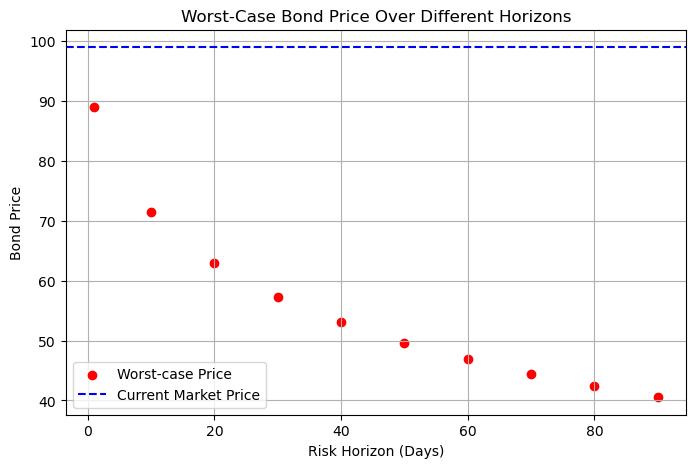

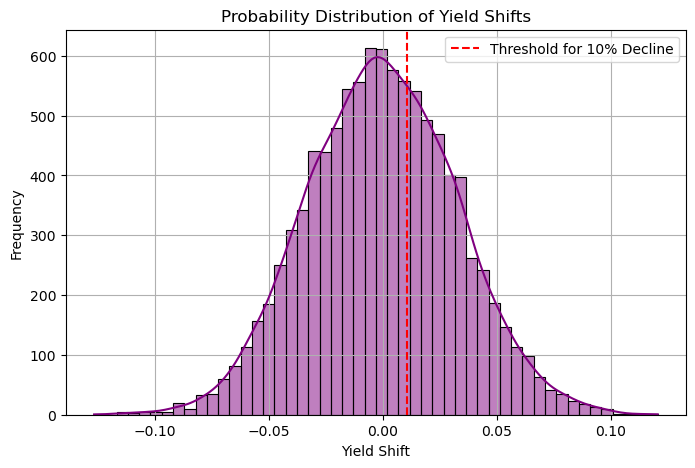

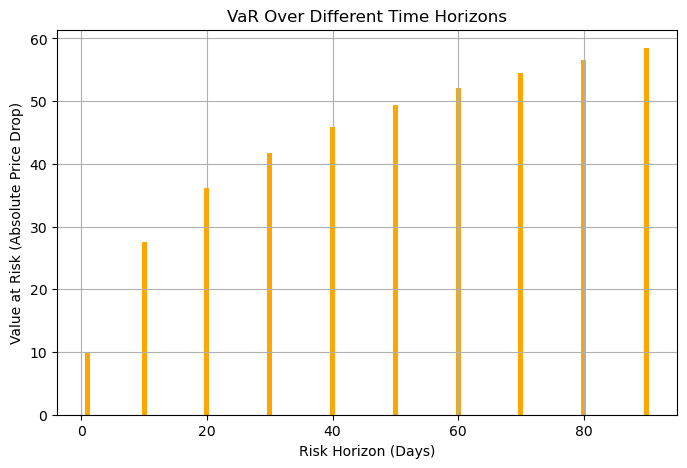

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example parameters (Ensure to use the correct ones from your analysis)
face_value = 100
coupon_rate = 0.05  # 5%
market_price = 99
maturity = 10  # years
daily_sigma_YTM = 0.006  # Daily volatility of YTM

# Load the computed VaR DataFrame (df_var) from your analysis before running this script

# 1. Bond Price vs. Time to Maturity (Yield Curve)
plt.figure(figsize=(8, 5))
time_to_maturity = np.linspace(0.1, 10, 100)  # 10 years to near 0
ytm = 0.05  # Fixed YTM for illustration
annual_coupon = face_value * coupon_rate

bond_prices = [
    sum(annual_coupon / (1 + ytm) ** t for t in np.linspace(1, T, 100)) + face_value / (1 + ytm) ** T
    for T in time_to_maturity
]



# 2. Worst-Case YTM and Price for Different Horizons (VaR Analysis)
plt.figure(figsize=(8, 5))
plt.scatter(df_var["Horizon (days)"], df_var["Worst-case Price (Low)"], color="red", label="Worst-case Price")
plt.axhline(y=market_price, color="blue", linestyle="--", label="Current Market Price")
plt.xlabel("Risk Horizon (Days)")
plt.ylabel("Bond Price")
plt.title("Worst-Case Bond Price Over Different Horizons")
plt.legend()
plt.grid()
plt.show()

# 3. Probability Distribution of Yield Shifts
simulated_shifts = np.random.normal(0, daily_sigma_YTM * np.sqrt(30), 10000)
plt.figure(figsize=(8, 5))
sns.histplot(simulated_shifts, bins=50, kde=True, color="purple")
plt.axvline(x=-np.log(1 - 0.10) / maturity, color="red", linestyle="--", label="Threshold for 10% Decline")
plt.xlabel("Yield Shift")
plt.ylabel("Frequency")
plt.title("Probability Distribution of Yield Shifts")
plt.legend()
plt.grid()
plt.show()

# 4. VaR Over Time
plt.figure(figsize=(8, 5))
plt.bar(df_var["Horizon (days)"], df_var["VaR (99%)"], color="orange")
plt.xlabel("Risk Horizon (Days)")
plt.ylabel("Value at Risk (Absolute Price Drop)")
plt.title("VaR Over Different Time Horizons")
plt.grid()
plt.show()


In [45]:
# Update the Taylor approximation function with the correct Delta and Theta computation
def compute_var_taylor_approximation_with_fixed_theta(face_value, coupon_rate, market_price, maturity, daily_sigma_YTM, confidence_level=0.99):
    """
    Compute Value at Risk (VaR) using the first-order Taylor approximation (Duration method),
    incorporating the correctly computed Delta and Theta for a 1-day shift.
    """
    # Annual coupon payment
    annual_coupon = face_value * coupon_rate

    # Define bond pricing function to solve for YTM
    def bond_price(YTM, T):
        price = sum(annual_coupon / (1 + YTM) ** t for t in range(1, int(T) + 1))
        price += face_value / (1 + YTM) ** T
        return price

    # Solve for YTM numerically using full maturity
    def bond_price_solver(YTM):
        return bond_price(YTM, maturity) - market_price

    YTM_initial_guess = 0.05  # Starting guess
    YTM_solution = fsolve(bond_price_solver, YTM_initial_guess)[0]

    # Compute Delta using a small yield shift of 1/360
    dy = 1 / 360  # Small change in YTM

    # Compute bond price at current YTM
    P_YTM = bond_price(YTM_solution, maturity)

    # Compute bond price at YTM + dy (slightly higher yield)
    P_YTM_plus_dy = bond_price(YTM_solution + dy, maturity)

    # Compute Delta (change in bond price per unit of yield)
    delta_one_day_shift_exact = (P_YTM_plus_dy - P_YTM) / dy
    print(delta_one_day_shift_exact)

    # Compute Theta using a small time shift of 1/360 (1-day shift)
    dt = 1 / 360  # Small change in time

    # Compute bond price at current maturity
    P_T = bond_price(YTM_solution, maturity)

    # Compute bond price at T - dt (one day later)
    P_T_minus_dt = bond_price(YTM_solution, maturity - dy)

    # Compute Theta (change in bond price per unit of time)
    theta_one_day_shift_exact = (P_T_minus_dt - P_T) / dy
    print(theta_one_day_shift_exact)

    # Define horizons in days
    horizons = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # [1, 10, 20, ..., 90]

    # Compute z-score for confidence level (e.g., 99% -> 2.33)
    z_alpha = abs(np.percentile(np.random.normal(0, 1, 100000), (1 - confidence_level) * 100))

    # Compute worst-case yield shift (ΔYTM)
    worst_case_YTM_shifts = z_alpha * daily_sigma_YTM * np.sqrt(horizons)

    # Compute bond price change using first-order Taylor approximation
    price_changes_approx = -delta_one_day_shift_exact * worst_case_YTM_shifts - 2.72 * (np.array(horizons) / 360)

    # Compute VaR as absolute drop in price
    VaRs_approx = np.abs(price_changes_approx)

    # Store results in DataFrame
    df_var_taylor_with_fixed_theta = pd.DataFrame({
        "Horizon (days)": horizons,
        "Worst-case Yield Shift (ΔYTM)": worst_case_YTM_shifts,
        "Price Change (Approx)": price_changes_approx,
        "VaR (99%) - Taylor Approx.": VaRs_approx
    })

    return df_var_taylor_with_fixed_theta


# Compute VaR using the updated Taylor approximation with the correct Delta and fixed Theta calculation
df_var_taylor_with_fixed_theta = compute_var_taylor_approximation_with_fixed_theta(face_value, coupon_rate, market_price, maturity, daily_sigma_YTM)

df_var_taylor_with_fixed_theta


-752.304359801326
-1088.387484530341


,Horizon (days),Worst-case Yield Shift (ΔYTM),Price Change (Approx),VaR (99%) - Taylor Approx.
0,1,0.014043,10.557267,10.557267
1,10,0.044409,33.333346,33.333346
2,20,0.062803,47.096211,47.096211
3,30,0.076918,57.639249,57.639249
4,40,0.088818,66.515582,66.515582
5,50,0.099301,74.326798,74.326798
6,60,0.108779,81.381429,81.381429
7,70,0.117495,87.862757,87.862757
8,80,0.125607,93.890200,93.890200
9,90,0.133226,99.546706,99.546706


In [48]:
def compute_var_delta_gamma_approximation(face_value, coupon_rate, market_price, maturity, daily_sigma_YTM, confidence_level=0.99):
    """
    Compute Value at Risk (VaR) using the second-order Delta-Gamma approximation.
    """
    # Annual coupon payment
    annual_coupon = face_value * coupon_rate

    # Define bond pricing function to solve for YTM
    def bond_price(YTM, T):
        price = sum(annual_coupon / (1 + YTM) ** t for t in range(1, int(T) + 1))
        price += face_value / (1 + YTM) ** T
        return price - market_price  # Solve for zero

    # Solve for YTM numerically using full maturity
    YTM_initial_guess = 0.05  # Starting guess
    YTM_solution = fsolve(bond_price, YTM_initial_guess, args=(maturity,))[0]

    # Compute bond price at current YTM
    P_YTM = bond_price(YTM_solution, maturity)
    dy = 1 / 360
    # Compute bond price at YTM + dy (slightly higher yield)
    P_YTM_plus_dy = bond_price(YTM_solution + dy, maturity)


    # Compute Delta (change in bond price per unit of yield)
    delta_one_day_shift_exact = (P_YTM_plus_dy - P_YTM) / dy

    # Compute Convexity
    convexity = sum(
        t * (t + 1) * (annual_coupon / (1 + YTM_solution) ** (t + 2)) for t in range(1, int(maturity) + 1)
    ) + maturity * (maturity + 1) * (face_value / (1 + YTM_solution) ** (maturity + 2))

    convexity /= market_price  # Normalize by bond price

    # Define horizons in days
    horizons = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # [1, 10, 20, ..., 90]

    # Compute z-score for confidence level (e.g., 99% -> 2.33)
    z_alpha = abs(np.percentile(np.random.normal(0, 1, 100000), (1 - confidence_level) * 100))

    # Compute worst-case yield shift (ΔYTM)
    worst_case_YTM_shifts = z_alpha * daily_sigma_YTM * np.sqrt(horizons)

    # Compute bond price change using Delta-Gamma approximation
    price_changes_delta_gamma = (delta_one_day_shift_exact * worst_case_YTM_shifts +
                                 0.5 * convexity * market_price * worst_case_YTM_shifts ** 2 - 2.72 * (np.array(horizons) / 360))

    # Compute VaR as absolute drop in price
    VaRs_delta_gamma = np.abs(price_changes_delta_gamma)

    # Store results in DataFrame
    df_var_delta_gamma = pd.DataFrame({
        "Horizon (days)": horizons,
        "Worst-case Yield Shift (ΔYTM)": worst_case_YTM_shifts,
        "Price Change (Delta-Gamma Approx)": price_changes_delta_gamma,
        "VaR (99%) - Delta-Gamma Approx.": VaRs_delta_gamma
    })

    return df_var_delta_gamma

# Compute VaR using Delta-Gamma approximation
df_var_delta_gamma = compute_var_delta_gamma_approximation(face_value, coupon_rate, market_price, maturity, daily_sigma_YTM)

df_var_delta_gamma



,Horizon (days),Worst-case Yield Shift (ΔYTM),Price Change (Delta-Gamma Approx),VaR (99%) - Delta-Gamma Approx.
0,1,0.014032,-9.835790,9.835790
1,10,0.044372,-26.178660,26.178660
2,20,0.062751,-32.803116,32.803116
3,30,0.076854,-36.210423,36.210423
4,40,0.088744,-37.952410,37.952410
5,50,0.099218,-38.630168,38.630168
6,60,0.108688,-38.551969,38.551969
7,70,0.117397,-37.900944,37.900944
8,80,0.125502,-36.796411,36.796411
9,90,0.133115,-35.321250,35.321250


In [49]:
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import fsolve
import pandas as pd
import matplotlib.pyplot as plt
import time

face_value = 100 
coupon_rate = 0.05 
coupon_payment = face_value * coupon_rate 
price = 99  
maturity = 10  
compounding_periods = 1  
ytm_mu = 0
ytm_std = 0.006  
time_horizons = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90]  
z_99 = stats.norm.ppf(0.01) 

# Find bond price with given YTM
def bond_price(ytm, face_value, coupon_payment, periods):
  
    return sum(coupon_payment / (1 + ytm) ** t for t in range(1, periods + 1)) + face_value / (1 + ytm) ** periods


# Solve YTM
def ytm_function(y, target_price, face_value, coupon_payment, periods):
    """
    Equation to solve for YTM that results in the target bond price.
    """
    return bond_price(y, face_value, coupon_payment, periods) - target_price

# Solve YTM
ytm_solution = fsolve(ytm_function, 0.05, args=(price, face_value, coupon_payment, maturity))[0]


# Compute Delta using the exact formula
delta_exact = -sum(t * coupon_payment / (1 + ytm_solution) ** (t + 1) for t in range(1, maturity + 1)) 
delta_exact -= maturity * face_value / (1 + ytm_solution) ** (maturity + 1)

delta_mu = -sum(t * coupon_payment / (1 + 0) ** (t + 1) for t in range(1, maturity + 1)) 
delta_mu -= maturity * face_value / (1 + 0) ** (maturity + 1)

# Compute Gamma using the exact formula
gamma_exact = sum(t * (t + 1) * coupon_payment / (1 + ytm_solution) ** (t + 2) for t in range(1, maturity + 1)) 
gamma_exact += maturity * (maturity + 1) * face_value / (1 + ytm_solution) ** (maturity + 2)

gamma_mu = sum(t * (t + 1) * coupon_payment / (1 + 0) ** (t + 2) for t in range(1, maturity + 1)) 
gamma_mu += maturity * (maturity + 1) * face_value / (1 + 0) ** (maturity + 2)

# Display results
print(f"YTM Solution: {ytm_solution:.6f}")
print(f"Delta (Exact): {delta_exact:.6f}")
print(f"Gamma (Exact): {gamma_exact:.6f}")


YTM Solution: 0.051303
Delta (Exact): -762.469057
Gamma (Exact): 7393.126767


In [50]:
def bond_price_fractional(ytm, face_value, coupon_payment, maturity_years, day_count=360):

    # Split into full years and fractional remainder
    full_years = int(maturity_years)  # Number of full years
    fractional_part = maturity_years - full_years  # Remaining fraction of a year

    # Discounted sum of **full-year** coupon payments
    coupon_pv = sum(coupon_payment / (1 + ytm) ** t for t in range(1, full_years + 1))

    # Discount the **last fractional coupon payment** (adjusted for the 360-day convention)
    if fractional_part > 0:
        last_coupon_discount = (coupon_payment / (1 + ytm) ** (full_years + fractional_part))
    else:
        last_coupon_discount = 0

    # Discount the **face value at full maturity**
    face_value_pv = face_value / (1 + ytm) ** maturity_years

    # Total bond price
    return coupon_pv + last_coupon_discount + face_value_pv

# Compute Theta using the finite difference approximation
delta_t = 1 / 360


# Bond price after a small time step (one period closer to maturity)
bond_price_t_plus = bond_price_fractional(ytm_solution, face_value, coupon_payment, (10- 1/360), day_count=360)

print(bond_price_t_plus)
# Compute Theta using finite difference approximation
theta_exact = (bond_price_t_plus - 99) / (-1/360)

# Display Theta
print(f"Theta (Exact): {theta_exact:.6f}")

99.00884855810727
Theta (Exact): -3.185481


In [51]:
# Compute the critical YTM (Y_critical) at which the bond price falls by 10%

price_threshold = 0.9 * price  # 10% decline in bond price
ytm_critical = fsolve(ytm_function, ytm_solution, args=(price_threshold, face_value, coupon_payment, maturity))[0]

# Compute probability using normal distribution (YTM is normally distributed)
sigma_ytm_30 = ytm_std * np.sqrt(30)  # Standard deviation over 30 days
probability = 1 - norm.cdf((ytm_critical - ytm_solution) / sigma_ytm_30)

# Display results
print(f"YTM for 10% price drop: {ytm_critical:.6f}")
print(f"Probability of 10% drop in 30 days: {float(probability):.4f}")

YTM for 10% price drop: 0.065175
Probability of 10% drop in 30 days: 0.3365


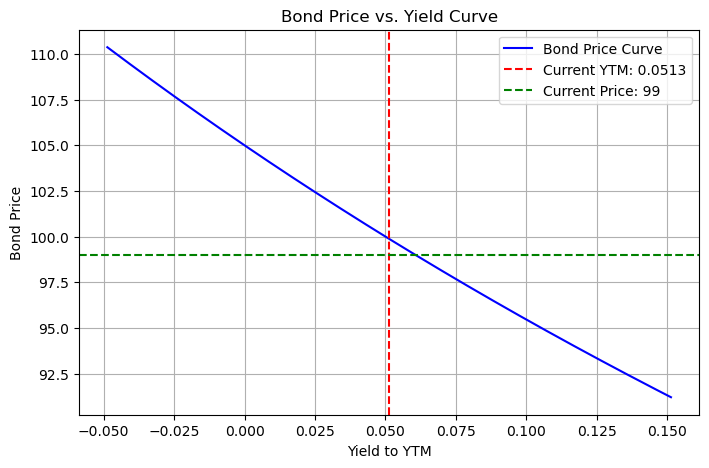

In [52]:
# Price-YTM plot
ytm_range = np.linspace(ytm_solution - 0.1, ytm_solution + 0.1, 500) 

prices = [bond_price(y, face_value, coupon_payment, compounding_periods) for y in ytm_range]

plt.figure(figsize=(8, 5))
plt.plot(ytm_range, prices, label="Bond Price Curve", color="blue")
plt.axvline(x= float(ytm_solution), linestyle="--", color="red", label=f"Current YTM: {float(ytm_solution):.4f}")
plt.axhline(y=price, linestyle="--", color="green", label=f"Current Price: {price}")

plt.xlabel("Yield to YTM")
plt.ylabel("Bond Price")
plt.title("Bond Price vs. Yield Curve")
plt.legend()
plt.grid()


plt.show()

In [53]:
# Generate normally distributed yield fluctuations
num_simulations = 100000  # Number of Monte Carlo simulations
var_99_bond_price_4 = {}
var_99_bond_price_5 = {}
var_99_bond_price_6 = {}

In [54]:
# Question 4: Compute bond price using Delta-Approximation Formula (with theta)
start_time = time.time()
for T in time_horizons:
    # Simulate daily yield fluctuations and accumulate them over T days
    delta_y_samples = np.random.normal(loc=0, scale=ytm_std, size=(num_simulations, T))
    ytm_fluc = np.sum(delta_y_samples, axis=1)  # Accumulate daily fluctuations


    # Compute bond prices for simulated YTMs
    bond_prices = price + delta_exact * ytm_fluc + theta_exact*(-T/360)

    
    # Compute 99% VaR as the difference between current price and 1st percentile of simulated prices
    var_99_bond_price_4[T] = price - np.percentile(bond_prices, 1)
   

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The code took {elapsed_time} seconds to run.")

# Display results
for T in time_horizons:
    print(f"Time Horizon: {T} days")
    print(f"99% VaR of Bond Price (Delta Approximation): {var_99_bond_price_4[T]:.6f}\n")

The code took 1.5828828811645508 seconds to run.
Time Horizon: 1 days
99% VaR of Bond Price (Delta Approximation): 10.619693

Time Horizon: 10 days
99% VaR of Bond Price (Delta Approximation): 33.295641

Time Horizon: 20 days
99% VaR of Bond Price (Delta Approximation): 47.569538

Time Horizon: 30 days
99% VaR of Bond Price (Delta Approximation): 58.114147

Time Horizon: 40 days
99% VaR of Bond Price (Delta Approximation): 67.100116

Time Horizon: 50 days
99% VaR of Bond Price (Delta Approximation): 74.668444

Time Horizon: 60 days
99% VaR of Bond Price (Delta Approximation): 81.664258

Time Horizon: 70 days
99% VaR of Bond Price (Delta Approximation): 88.173914

Time Horizon: 80 days
99% VaR of Bond Price (Delta Approximation): 93.949962

Time Horizon: 90 days
99% VaR of Bond Price (Delta Approximation): 99.650215



In [55]:
# Question 5: Compute bond price using Delta-Gamma-Approximation Formula (with theta)
start_time = time.time()

for T in time_horizons:
    # Simulate daily yield fluctuations and accumulate them over T days
    delta_y_samples = np.random.normal(loc=0, scale=ytm_std, size=(num_simulations, T))
    ytm_fluc = np.sum(delta_y_samples, axis=1)  # Accumulate daily fluctuations

    # Compute bond prices using Delta-Gamma Approximation
    bond_prices = price + delta_exact * ytm_fluc + 0.5 * gamma_exact * (ytm_fluc ** 2) + theta_exact*(-T/360)

    # Compute 99% VaR as the difference between current price and 1st percentile of simulated prices
    var_99_bond_price_5[T] = price - np.percentile(bond_prices, 1)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"The code took {elapsed_time} seconds to run.")

# Display results
for T in time_horizons:
    print(f"Time Horizon: {T} days")
    print(f"99% VaR of Bond Price (Delta-Gamma Approximation): {var_99_bond_price_5[T]:.6f}\n")

The code took 1.437880039215088 seconds to run.
Time Horizon: 1 days
99% VaR of Bond Price (Delta-Gamma Approximation): 9.966386

Time Horizon: 10 days
99% VaR of Bond Price (Delta-Gamma Approximation): 26.418367

Time Horizon: 20 days
99% VaR of Bond Price (Delta-Gamma Approximation): 33.017645

Time Horizon: 30 days
99% VaR of Bond Price (Delta-Gamma Approximation): 36.440416

Time Horizon: 40 days
99% VaR of Bond Price (Delta-Gamma Approximation): 38.012421

Time Horizon: 50 days
99% VaR of Bond Price (Delta-Gamma Approximation): 38.485947

Time Horizon: 60 days
99% VaR of Bond Price (Delta-Gamma Approximation): 38.622516

Time Horizon: 70 days
99% VaR of Bond Price (Delta-Gamma Approximation): 38.600485

Time Horizon: 80 days
99% VaR of Bond Price (Delta-Gamma Approximation): 38.544467

Time Horizon: 90 days
99% VaR of Bond Price (Delta-Gamma Approximation): 38.471088



In [56]:
# Question 6: Compute 99% VaR using the original bond price formula with yield fluctuations (with time deduction)
start_time = time.time()


for T in time_horizons:
    # Simulate daily yield fluctuations and accumulate them over T days
    delta_y_samples = np.random.normal(loc=0, scale=ytm_std, size=(num_simulations, T))
    ytm_samples = ytm_solution + np.sum(delta_y_samples, axis=1)  # Accumulate daily fluctuations
    
    # Compute bond prices for simulated YTMs
    bond_prices = bond_price_fractional(ytm_samples, face_value, coupon_payment, (maturity - T/360), day_count=360)
    
    # Compute 99% VaR as the difference between current price and 1st percentile of simulated prices
    var_99_bond_price_6[T] = price - np.percentile(bond_prices, 1)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"The code took {elapsed_time} seconds to run.")
# Display results
for T in time_horizons:
    print(f"Time Horizon: {T} days")
    print(f"99% VaR of Bond Price (Full Revaluation): {var_99_bond_price_6[T]:.6f}\n")

The code took 1.801682949066162 seconds to run.
Time Horizon: 1 days
99% VaR of Bond Price (Full Revaluation): 9.970771

Time Horizon: 10 days
99% VaR of Bond Price (Full Revaluation): 27.443415

Time Horizon: 20 days
99% VaR of Bond Price (Full Revaluation): 35.563454

Time Horizon: 30 days
99% VaR of Bond Price (Full Revaluation): 41.081630

Time Horizon: 40 days
99% VaR of Bond Price (Full Revaluation): 45.353032

Time Horizon: 50 days
99% VaR of Bond Price (Full Revaluation): 48.627643

Time Horizon: 60 days
99% VaR of Bond Price (Full Revaluation): 51.438456

Time Horizon: 70 days
99% VaR of Bond Price (Full Revaluation): 53.823122

Time Horizon: 80 days
99% VaR of Bond Price (Full Revaluation): 55.836961

Time Horizon: 90 days
99% VaR of Bond Price (Full Revaluation): 57.212039



In [57]:
 #Compute the Expected Shortfall of your bond at a 99% confidence level for different horizons

var_99_bond_price_6 = {}
es_99_bond_price_6 = {}

for T in time_horizons:
    
    # Simulate daily yield fluctuations and accumulate them over T days
    delta_y_samples = np.random.normal(loc=0, scale=ytm_std, size=(num_simulations, T))
    ytm_samples = ytm_solution + np.sum(delta_y_samples, axis=1)  # Accumulate daily fluctuations
    
    # Compute bond prices for simulated YTMs
    bond_prices =  bond_price_fractional(ytm_samples, face_value, coupon_payment, (maturity - T/360), day_count=360)
    
    # Compute 99% VaR as the difference between current price and 1st percentile of simulated prices
    var_99_bond_price_6[T] = price - np.percentile(bond_prices, 1)
    
    # Compute 99% Expected Shortfall (ES) as the average of worst 1% simulated bond prices
    es_99_bond_price_6[T] = price - np.mean(bond_prices[bond_prices <= np.percentile(bond_prices, 1)])

# Display results
for T in time_horizons:
    print(f"Time Horizon: {T} days")
    print(f"99% VaR of Bond Price (Full Revaluation): {var_99_bond_price_6[T]:.6f}")
    print(f"99% Expected Shortfall (ES) of Bond Price: {es_99_bond_price_6[T]:.6f}\n")

Time Horizon: 1 days
99% VaR of Bond Price (Full Revaluation): 9.823739
99% Expected Shortfall (ES) of Bond Price: 11.232809

Time Horizon: 10 days
99% VaR of Bond Price (Full Revaluation): 27.376556
99% Expected Shortfall (ES) of Bond Price: 30.596312

Time Horizon: 20 days
99% VaR of Bond Price (Full Revaluation): 35.972472
99% Expected Shortfall (ES) of Bond Price: 39.529529

Time Horizon: 30 days
99% VaR of Bond Price (Full Revaluation): 41.370011
99% Expected Shortfall (ES) of Bond Price: 45.239066

Time Horizon: 40 days
99% VaR of Bond Price (Full Revaluation): 45.236569
99% Expected Shortfall (ES) of Bond Price: 49.202284

Time Horizon: 50 days
99% VaR of Bond Price (Full Revaluation): 48.771702
99% Expected Shortfall (ES) of Bond Price: 52.729838

Time Horizon: 60 days
99% VaR of Bond Price (Full Revaluation): 51.097616
99% Expected Shortfall (ES) of Bond Price: 54.966062

Time Horizon: 70 days
99% VaR of Bond Price (Full Revaluation): 53.250715
99% Expected Shortfall (ES) of B

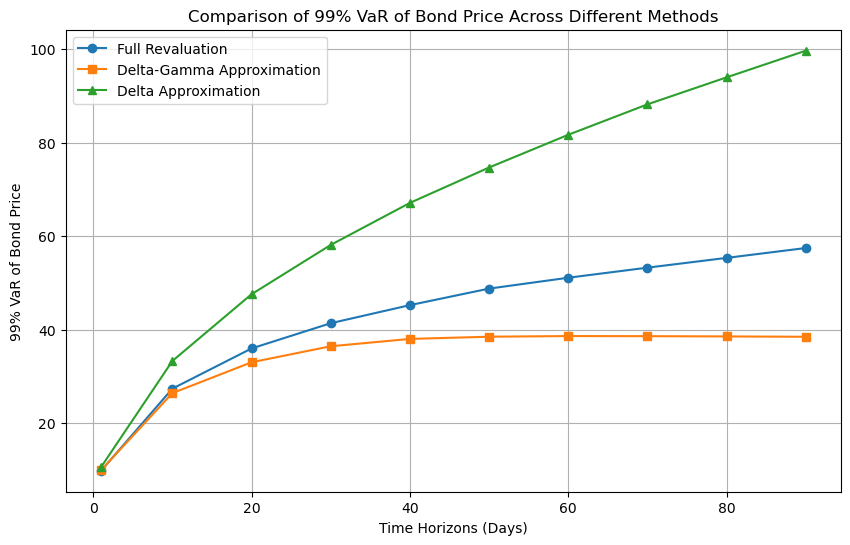

In [58]:

# Plotting the data



var_full = list(var_99_bond_price_6.values())
var_delta_gamma = list(var_99_bond_price_5.values())
var_delta = list(var_99_bond_price_4.values())

plt.figure(figsize=(10, 6))
plt.plot(time_horizons, var_full, marker='o', label='Full Revaluation')
plt.plot(time_horizons, var_delta_gamma, marker='s', label='Delta-Gamma Approximation')
plt.plot(time_horizons, var_delta, marker='^', label='Delta Approximation')

# Adding labels and title
plt.xlabel('Time Horizons (Days)')
plt.ylabel('99% VaR of Bond Price')
plt.title('Comparison of 99% VaR of Bond Price Across Different Methods')
plt.legend()

# Displaying the grid
plt.grid(True)

# Show the plot
plt.show()

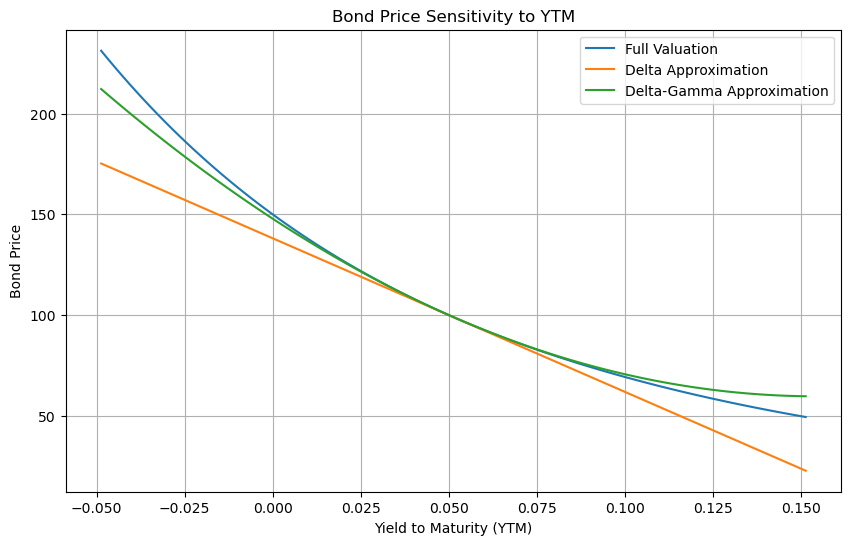

In [59]:
# Generating a range of YTM values around the given YTM
ytm_samples = np.linspace(0.051303 - 0.1, 0.051303 + 0.1, 100)

# Calculate full bond prices
bond_prices_full = [bond_price(ytm, face_value, coupon_payment, maturity) for ytm in ytm_samples]

# Calculate bond prices using Delta approximation
bond_prices_delta = [price + delta_exact * (ytm_sample - 0.051303) for ytm_sample in ytm_samples]

# Calculate bond prices using Delta-Gamma approximation
bond_prices_delta_gamma = [price + delta_exact * (ytm_sample - 0.051303) + 0.5 * gamma_exact * ((ytm_sample - 0.051303) ** 2) for ytm_sample in ytm_samples]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(ytm_samples, bond_prices_full, label='Full Valuation')
plt.plot(ytm_samples, bond_prices_delta, label='Delta Approximation')
plt.plot(ytm_samples, bond_prices_delta_gamma, label='Delta-Gamma Approximation')

# Adding labels and title
plt.xlabel('Yield to Maturity (YTM)')
plt.ylabel('Bond Price')
plt.title('Bond Price Sensitivity to YTM')
plt.legend()

# Display the grid
plt.grid(True)

# Show the plot
plt.show()